# Analyzing Breast Cancer Diagnosis with FHE-Enabled Neural Networks

In this example, we show how one can train a neural network on a specific task (here, Breast Cancer Diagnosis) and convert it to its FHE counterpart such that it runs over encrypted data.

In [ ]:
#!pip install -U pip wheel setuptools
#!pip install concrete-ml

In [1]:
import time

import numpy as np
from matplotlib import pyplot as plt
from sklearn.datasets import load_breast_cancer
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from torch import nn
from tqdm import tqdm

from concrete.ml.sklearn import NeuralNetClassifier

/home/moyed/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### 1. Data Loading and Preliminary Analysis

In this section, we load the Breast Cancer Wisconsin (Diagnostic) dataset and split it into training and test sets to prepare for model training.  We ensure the data types are compatible with the Concret ML neural network models by converting them to `float32`.



In [2]:
# Load breast cancer dataset
cancer = load_breast_cancer()
X, y = cancer.data, cancer.target

# Information about the dataset
print("Total number of samples:", X.shape[0])
print("Number of features per sample:", X.shape[1])
print("Feature names:", cancer.feature_names)
print("Target names (Classes):", cancer.target_names)
print("Total number of classes:", len(cancer.target_names))

# Split into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

# Scikit-Learn and Concrete ML neural networks only handle float32 input values
X_train, X_test = X_train.astype("float32"), X_test.astype("float32")

# Display a portion of the training and testing data
print("\nTraining Data Samples:")
print(X_train[:5])  # Display first 5 samples of training data
print("Training Data Labels:")
print(y_train[:5])  # Display labels of the first 5 samples of training data

# Display test data information
print("\nTesting Data Samples:")
print(X_test[:5])  # Display first 5 samples of testing data
print("Testing Data Labels:")
print(y_test[:5])  # Display labels of the first 5 samples of testing data


Total number of samples: 569
Number of features per sample: 30
Feature names: ['mean radius' 'mean texture' 'mean perimeter' 'mean area'
 'mean smoothness' 'mean compactness' 'mean concavity'
 'mean concave points' 'mean symmetry' 'mean fractal dimension'
 'radius error' 'texture error' 'perimeter error' 'area error'
 'smoothness error' 'compactness error' 'concavity error'
 'concave points error' 'symmetry error' 'fractal dimension error'
 'worst radius' 'worst texture' 'worst perimeter' 'worst area'
 'worst smoothness' 'worst compactness' 'worst concavity'
 'worst concave points' 'worst symmetry' 'worst fractal dimension']
Target names (Classes): ['malignant' 'benign']
Total number of classes: 2

Training Data Samples:
[[1.289e+01 1.312e+01 8.189e+01 5.159e+02 6.955e-02 3.729e-02 2.260e-02
  1.171e-02 1.337e-01 5.581e-02 1.532e-01 4.690e-01 1.115e+00 1.268e+01
  4.731e-03 1.345e-02 1.652e-02 5.905e-03 1.619e-02 2.081e-03 1.362e+01
  1.554e+01 8.740e+01 5.770e+02 9.616e-02 1.147e-01 1

### 2. Model Training and Performance Evaluation
We benchmark the scikit-learn model against our neural network to compare their performance. After training, we evaluate both models on the test set. The accuracy scores provide a clear metric for comparing the predictive power of the conventional scikit-learn model and the Concrete ML simulated model using simulation mode.


In [3]:
params = {
    "module__n_layers": 3,
    "module__activation_function": nn.ReLU,
    "max_epochs": 1000,
    "verbose": 0,
}
model = NeuralNetClassifier(**params)

In [4]:
model, sklearn_model = model.fit_benchmark(X=X_train, y=y_train)

In [5]:
# Evaluate the sklearn model, which needs to specifically be of type float32
y_pred_sklearn = sklearn_model.predict(X_test)

sklearn_accuracy = accuracy_score(y_test, y_pred_sklearn) * 100
print(f"The test accuracy of the trained scikit-learn model is {sklearn_accuracy:.2f}%")

The test accuracy of the trained scikit-learn model is 95.80%


In [6]:
# Evaluate the Concrete ML model in the clear
y_pred_simulated = model.predict(X_test)

simulated_accuracy = accuracy_score(y_test, y_pred_simulated) * 100
print(f"The test accuracy of the trained Concrete ML simulated model is {simulated_accuracy:.2f}%")

The test accuracy of the trained Concrete ML simulated model is 79.02%


### 3. FHE Model Compilation and Key Generation
We now compile the previously trained model for secure FHE operation, which involves constructing an encrypted computational graph. This step includes generating a cryptographic key tailored to the circuit's bit-width requirements. 

3.1 Compile model

In [7]:
# Compile the model to have before
fhe_circuit = model.compile(X_train)

3.2 Generate the key

In [8]:
print("Generating a key for a " f"{fhe_circuit.graph.maximum_integer_bit_width()}-bit circuit")

Generating a key for a 9-bit circuit


In [9]:
time_begin = time.time()
fhe_circuit.client.keygen(force=True)
print(f"Key generation time: {time.time() - time_begin:.2f} seconds")

Key generation time: 8.79 seconds


### 4. Executing FHE Predictions and Comparing Model Accuracies
We execute the FHE model on our test data, measuring the time taken per sample to understand the computational overhead of FHE. After obtaining the predictions, we calculate the model's accuracy, enabling a direct comparison with the previously evaluated scikit-learn and simulated Concrete ML models. 


4.1 Predict in FHE

In [10]:
fhe_predictions = []
time_begin = time.time()
for x in tqdm(X_test):
    y_ = model.predict(np.array([x]), fhe="execute")[0]
    fhe_predictions.append(y_)

print(f"Execution time: {(time.time() - time_begin) / len(X_test):.2f} seconds per sample")

100%|██████████| 143/143 [42:46<00:00, 17.95s/it] 

Execution time: 17.95 seconds per sample


4.2 Compare the accuracy scores

In [11]:
fhe_accuracy = accuracy_score(y_test, fhe_predictions) * 100

print(f"Test accuracy using the sklearn model: {sklearn_accuracy:.2f}%")
print(f"Test accuracy using the Concrete ML simulated model: {simulated_accuracy:.2f}%")
print(f"Test accuracy using the Concrete ML FHE model: {fhe_accuracy:.2f}%")

Test accuracy using the sklearn model: 95.80%
Test accuracy using the Concrete ML simulated model: 79.02%
Test accuracy using the Concrete ML FHE model: 79.02%


### 5. Model Visualization and Evaluation

We first visualize the decision boundaries of our models using PCA-reduced data and grid predictions, which helps in understanding how each model classifies different regions of the feature space. Following this, we delve into a detailed evaluation, presenting classification reports and ROC curves for both the scikit-learn and FHE models. This comprehensive analysis includes metrics like precision, recall, F1-score, and AUC, offering insights into each model's predictive accuracy and capability to distinguish between the classes in the breast cancer dataset.


5.1 Visualizing decision boundaries

In [12]:
# Create a 2D grid in order to visualize predictions and contours for both models
pca = PCA(n_components=2, random_state=np.random.randint(0, 2**15))
X_test_2d = pca.fit_transform(X_test)

b_min = np.min(X_test_2d, axis=0)
b_max = np.max(X_test_2d, axis=0)

grid_dims = tuple(
    np.linspace(b_min[i], b_max[i], 512, dtype=X_test.dtype) for i in range(X_test_2d.shape[1])
)
ndgrid_tuple = np.meshgrid(*grid_dims)
grid_2d = np.vstack([g.ravel() for g in ndgrid_tuple]).transpose()

grid_test = pca.inverse_transform(grid_2d)

# Evaluate the predicted classes using the sklearn model
grid_pred_sklearn = sklearn_model.predict_proba(grid_test)
pred_sklearn_classes = np.argmax(grid_pred_sklearn, axis=1)

# Evaluate the predicted classes using the Concrete ML simulated model
# Pylint is disabled because it does not seem to be able to understand that `model` is a
# NeuralClassifier instance and support the predict_proba method. This may be solved by removing
# Skorch and Sklearn inheritance
# FIXME: https://github.com/zama-ai/concrete-ml-internal/issues/3373
grid_pred_fhe = model.predict_proba(grid_test)  # pylint: disable=no-member
pred_fhe_classes = np.argmax(grid_pred_fhe, axis=1)

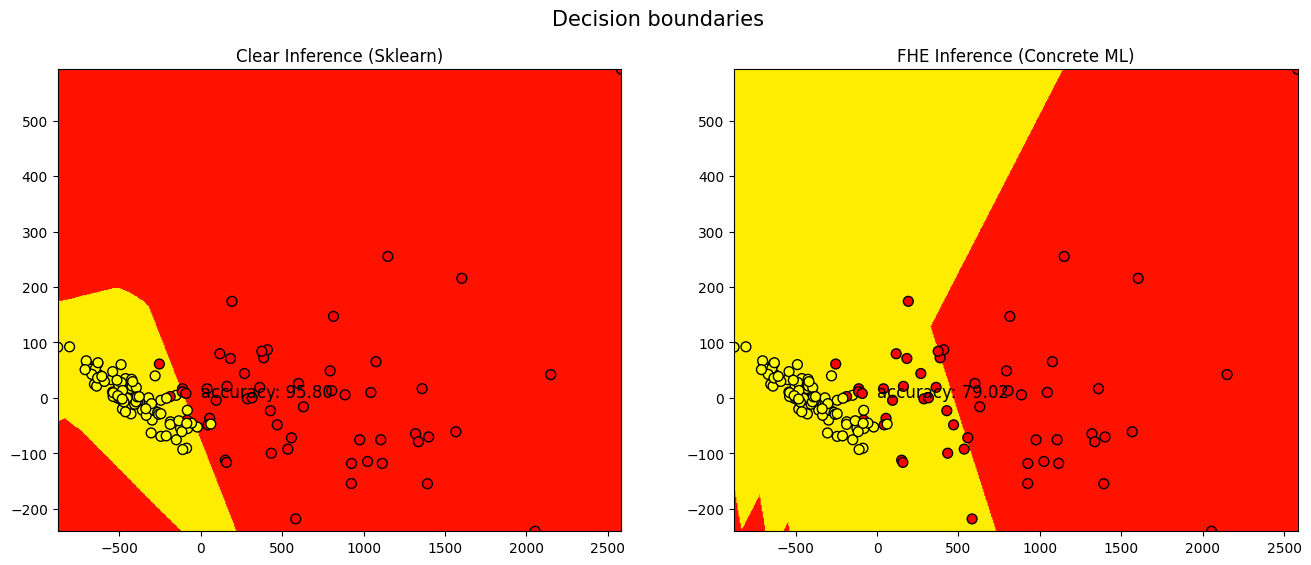

In [13]:
%matplotlib inline

cmap = "autumn"

classes_to_plot = [
    (pred_sklearn_classes, "Clear Inference (Sklearn)", sklearn_accuracy),
    (pred_fhe_classes, "FHE Inference (Concrete ML)", simulated_accuracy),
]

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

for i, (classes, title, accuracy) in enumerate(classes_to_plot):
    ax = axes[i]

    # Plot contours based on the predicted classes
    ax.contourf(
        ndgrid_tuple[0],
        ndgrid_tuple[1],
        classes.reshape(ndgrid_tuple[0].shape),
        cmap=cmap,
        label="ookko",
    )

    # Set the title and legend text
    ax.set_title(title)
    ax.text(1.6, 1, f"accuracy: {accuracy:.2f}", size=12)

    # Plot the test data as a scatter with marker borders
    ax.scatter(X_test_2d[:, 0], X_test_2d[:, 1], c=y_test, s=50, edgecolors="k", cmap=cmap)

fig.suptitle("Decision boundaries", size=15)
plt.show()

5.2 Detailed model evaluation


Scikit-learn Model Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.94      0.94        54
           1       0.97      0.97      0.97        89

    accuracy                           0.96       143
   macro avg       0.96      0.96      0.96       143
weighted avg       0.96      0.96      0.96       143

FHE Model Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.46      0.62        54
           1       0.75      0.99      0.85        89

    accuracy                           0.79       143
   macro avg       0.86      0.73      0.74       143
weighted avg       0.83      0.79      0.77       143



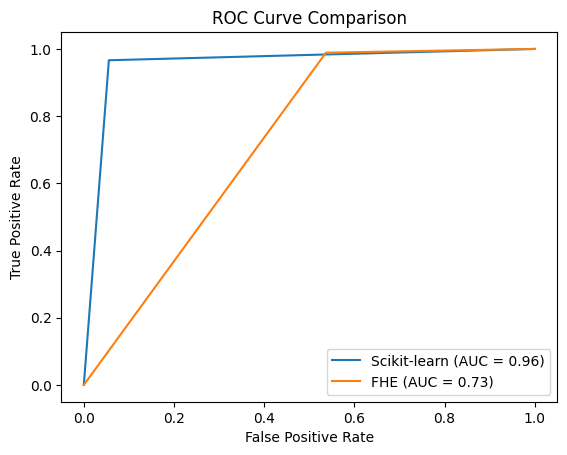

In [16]:
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
import time

# Assume pred_sklearn and pred_fhe are the predictions from the scikit-learn and FHE models, respectively

# Accuracy Metrics
print("Scikit-learn Model Classification Report:")
print(classification_report(y_test, y_pred_sklearn))

print("FHE Model Classification Report:")
print(classification_report(y_test, fhe_predictions))

# Confusion Matrix
cm_sklearn = confusion_matrix(y_test, y_pred_sklearn)
cm_fhe = confusion_matrix(y_test, fhe_predictions)

# ROC Curve (for binary classification)
fpr_sklearn, tpr_sklearn, _ = roc_curve(y_test, y_pred_sklearn)
fpr_fhe, tpr_fhe, _ = roc_curve(y_test, fhe_predictions)

plt.figure()
plt.plot(fpr_sklearn, tpr_sklearn, label=f'Scikit-learn (AUC = {auc(fpr_sklearn, tpr_sklearn):.2f})')
plt.plot(fpr_fhe, tpr_fhe, label=f'FHE (AUC = {auc(fpr_fhe, tpr_fhe):.2f})')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison')
plt.legend()
plt.show()
